**Note:** This notebook investigates the impact of emoji and emoticon preprocessing on transformer-based emotion classification. The experiment is exploratory and included for supplementary analysis.

In [1]:
#mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1.Import Libraries

In [2]:
#main python and data handling libraries
import numpy as np
import pandas as pd
import os, random, re, html, unicodedata
from html import unescape
from collections import Counter

#visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#machine learning & evaluation metrics
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, precision_recall_curve, average_precision_score
from transformers import EarlyStoppingCallback

#transformers
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from transformers import(AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding)
from typing import List, Dict, Optional

import joblib
import sys

#add project root to Python path to import utils.py
sys.path.append('/content/drive/MyDrive/applied_research_project')
import utils

# 2.Load the GoEmotion Train, Test, and Val Splits from the official Google Research

In [3]:
#load the GoEmotions train split from the official Google Research Repository
train_url='https://raw.githubusercontent.com/google-research/google-research/refs/heads/master/goemotions/data/train.tsv'
train_df=pd.read_csv(train_url,sep='\t',header=None)

#change the colum names of the train split
train_df.columns = ["text", "emotion_id", "comment_id"]

In [4]:
#load the GoEmotions test split from the official Google Research Repository
test_url='https://raw.githubusercontent.com/google-research/google-research/refs/heads/master/goemotions/data/test.tsv'
test_df=pd.read_csv(test_url,sep='\t', header=None)

#change the colum names of the test split
test_df.columns = ["text", "emotion_id", "comment_id"]
test_df.head()

,text,emotion_id,comment_id
0,I’m really sorry about your situation :( Altho...,25,eecwqtt
1,It's wonderful because it's awful. At not with.,0,ed5f85d
2,"Kings fan here, good luck to you guys! Will be...",13,een27c3
3,"I didn't know that, thank you for teaching me ...",15,eelgwd1
4,They got bored from haunting earth for thousan...,27,eem5uti


In [5]:
#load the GoEmotions val split from the official Google Research Repository
val_url='https://raw.githubusercontent.com/google-research/google-research/refs/heads/master/goemotions/data/dev.tsv'
val_df=pd.read_csv(val_url, sep='\t', header=None)

#change the colum names of the val split
val_df.columns = ["text", "emotion_id", "comment_id"]
val_df.head()

,text,emotion_id,comment_id
0,Is this in New Orleans?? I really feel like th...,27,edgurhb
1,"You know the answer man, you are programmed to...","4,27",ee84bjg
2,I've never been this sad in my life!,25,edcu99z
3,The economy is heavily controlled and subsidiz...,"4,27",edc32e2
4,He could have easily taken a real camera from ...,20,eepig6r


In [6]:
#load the GoEmotions emotion list from the official Google Research Repository
emotions_url='https://raw.githubusercontent.com/google-research/google-research/refs/heads/master/goemotions/data/emotions.txt'
emotions=pd.read_csv(emotions_url,header=None)

# 3.Text Cleaning and Preprocessing Setup

## 3.1. Initial Cleaning and Deduplication

In [7]:
#drop comment_id column from all splits
train_df=train_df.drop(columns=["comment_id"])
test_df=test_df.drop(columns=["comment_id"])
val_df=val_df.drop(columns=["comment_id"])

In [8]:
#combine train, test, and val splits into one dataframe
df_all = pd.concat([train_df, test_df, val_df], ignore_index=True)

In [9]:
#merge emotion labels for duplicates with different emotion_ids

def merge_unique_duplicates(df, split="dataset"):
  num_before_merging=len(df)

  #convert the emotion_id column to a list
  def to_list(x):
      if not isinstance(x, str) or not x.strip():
        return []
      return [int(i) for i in x.split(',') if i]

  temp_df = df.copy()
  temp_df["emotion_id"] = temp_df["emotion_id"].apply(to_list)

  merged_df=(
      temp_df.groupby("text", as_index=False).agg({
          "emotion_id": lambda s: sorted(set(e for lst in s for e in lst))
      })
  )

  return merged_df

In [10]:
#merge train split and deduplicate test/val splits to avoid data leakage

ws_re = re.compile(r"\s+") #matches and collapse whitespaces

#create a deduplicate key by normalizing text to ensure duplicates can be identified across all splits
def deduplicate_key(s: str) -> str:
    if not isinstance(s, str):
        return ""
    return ws_re.sub(" ", html.unescape(s).lower()).strip()

#merge duplicate texts in train split and apply deduplication key
train_merged = merge_unique_duplicates(train_df, "Train")
train_merged["key"] = train_merged["text"].apply(deduplicate_key)

#deduplicate val and test splits, keep the first occurence, and apply deduplication key
val_deduplicate  = val_df.drop_duplicates(subset=["text"], keep="first").copy()
test_deduplicate = test_df.drop_duplicates(subset=["text"], keep="first").copy()

val_deduplicate["key"]  = val_deduplicate["text"].apply(deduplicate_key)
test_deduplicate["key"] = test_deduplicate["text"].apply(deduplicate_key)

#remove texts in val/test that also appear in train to avoid data leakage
train_keys = set(train_merged["key"])
val_final  = val_deduplicate[~val_deduplicate["key"].isin(train_keys)].reset_index(drop=True)
test_final = test_deduplicate[~test_deduplicate["key"].isin(train_keys)].reset_index(drop=True)

#remove deduplication key and retain original columns
train_final = train_merged[["text", "emotion_id"]].copy()
val_final   = val_final[["text", "emotion_id"]].copy()
test_final  = test_final[["text", "emotion_id"]].copy()

print(f"Train Split: {len(train_df):,}, after merging: {len(train_final):,}")
print(f"Test Split: {len(test_df):,}, after removing overlaps: {len(test_final):,} (overlaps removed: {len(test_df)-len(test_final):,})")
print(f"Val Split: {len(val_df):,}, after removing overlaps: {len(val_final):,}  (overlaps removed: {len(val_df)-len(val_final):,})")

Train Split: 43,410, after merging: 43,227
Test Split: 5,427, after removing overlaps: 5,384 (overlaps removed: 43)
Val Split: 5,426, after removing overlaps: 5,376  (overlaps removed: 50)


In [11]:
#confirm agin that val and test splits share no texts with training data
assert not set(val_final["text"].apply(deduplicate_key)).intersection(set(train_final["text"].apply(deduplicate_key)))
assert not set(test_final["text"].apply(deduplicate_key)).intersection(set(train_final["text"].apply(deduplicate_key)))

The assert statement in Python is used as a sanity check or validation.
It tests whether a condition is True.
If it’s True, nothing happens (the program continues).
If it’s False, Python raises an AssertionError, stopping the program and signaling that something’s wrong.


## 3.2 Handling Text Artifacts

In [12]:
#check the presence of html entities (&, <,>, ",', space) in all splits
html_entities=df_all['text'].str.contains(r"&(?:amp|lt|gt|quot|apos|nbsp);").any()

#check the presence of zero_width characters in all splits
zero_width_char=df_all['text'].str.contains(r"[\u0000-\u001F\u007F\u200B-\u200F\uFEFF\u115F\u1160\u3164\uFFA0\uFFFC\uFFF0-\uFFF8]").any()

print("Presence of HTML entities within all three splits:", html_entities)
print("Presence of zero_width characters within all three splits:", zero_width_char)

Presence of HTML entities within all three splits: False
Presence of zero_width characters within all three splits: True


In [13]:
#check count of patterns (emails, @-sign tokens, hashtags, subreddits, placeholders, etc.) within the text across all splits

regex_patterns = {
    "emails": r"""(?ix)\b[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,}\b""",
    "at_sign_front": r"(?<!\w)@[A-Za-z0-9_][A-Za-z0-9_-]*",
    "at_sign_inside":r"\b\w*@\w*\b",
    "hashtags_front": r"(?<!\w)#[A-Za-z0-9_][A-Za-z0-9_-]*",
    "hashtags_inside":r"\b\w+#\w+\b",
    "placeholders": r"(?i)(\[\s*[a-z0-9_-]+\s*\]|<\s*[a-z0-9_-]+\s*>)",
    "subreddits": r"\br/[A-Za-z0-9_]+",
    "user_subreddits":r"\bu/[A-Za-z0-9_-]+",
}

#extract and count regex pattern occurrences
def extract_and_count(df, text, pattern):
    regex = re.compile(pattern)
    vals = df[text].astype(str).apply(lambda x: regex.findall(x)).explode()
    counts = vals.value_counts(dropna=True).to_frame(name="count")
    return counts

results = {}
for name, pattern in regex_patterns.items():
    counts = extract_and_count(df_all, "text", pattern)
    results[name] = counts
    print(f"\n{name.upper()}:")
    display(counts)



EMAILS:


,count
text,



AT_SIGN_FRONT:


,count
text,
@11,1
@teamYouTube,1
@teamyoutube,1
@me,1
@IAMTHESmoothOperator,1
@AOC,1
@lies_about_flossing,1



AT_SIGN_INSIDE:


,count
text,
t@gged,1



HASHTAGS_FRONT:


,count
text,
#1,32
#2,8
#I,4
#4,3
#YES,3
...,...
#calledyourbluff,1
#12,1
#face-support,1



HASHTAGS_INSIDE:


,count
text,
xkcd#37,1



PLACEHOLDERS:


,count
text,
[NAME],9598
[RELIGION],132
[serious],2
[get_user_id],1
<smile>,1
[ALL],1
[goshdarn],1
[TEAM],1
[chuckles],1



SUBREDDITS:


,count
text,
r/politics,8
r/woooosh,6
r/funny,6
r/nba,5
r/niceguys,4
...,...
r/rant,1
r/zach,1
r/stlouis,1



USER_SUBREDDITS:


,count
text,
u/iBiteYou,1
u/The_White_Baron,1
u/Dr-Pepper-Phd,1
u/Reijka92,1
u/HAHAAN00B,1
...,...
u/wikilacks,1
u/Skraxx,1
u/hyunL,1


In [14]:
#handle emails, and at_signs tokens (at the front and inside of words)
def handle_email_atSigns(text: str) -> str:
  email_re = re.compile(r"""(?ix)\b[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,}\b""")
  atSign_front_re= re.compile(r"(?<!\w)@[A-Za-z0-9_][A-Za-z0-9_-]*")
  atSign_inside_re=re.compile(r"(?<=\w)@(?=\w)")

  text = email_re.sub(" <EMAIL> ", text)       #maps emails to <EMAIL>
  text = atSign_front_re.sub(" <USER> ", text) #maps to <USER> as '@' at the fron of word indicate mentions and tagged accounts
  text = atSign_inside_re.sub(" ", text)       #replace @ from the word with a whitespace
  text = re.sub(r"\s+", " ", text).strip()
  return text

In [15]:
#handle hashtags (at the front and inside of words)
def handle_hashtags(text: str) -> str:
  hashtag_inside_re=re.compile(r"(?<=\w)#(?=\w)")
  hashtag_start_re = re.compile(r"(?<!\w)#[A-Za-z0-9_][A-Za-z0-9_-]*")

  text = hashtag_inside_re.sub(" ", text) #replace hashtags with space
  text = hashtag_start_re.sub("", text)   #remove hashtag at the front of word

  return re.sub(r"\s+", " ", text).strip()

In [16]:
#handle placeholders
placeholder_re = re.compile(r"(?i)(\[\s*[a-z0-9_-]+\s*\]|<\s*[a-z0-9_-]+\s*>)") #matches placeholders with [], and <>

placeholder_map={
    #remove noise entirely
    "deleted": "", "get_user_id": "", "7": "", "t": "","all": "",

    #keep words that could provide emotion context
    "serious": "serious", "chuckles": "chuckles", "smile": "smile", "goshdarn": "goshdarn", "nice": "nice",

    #keep the placeholders
    "celebrity": "<ENTITY>", "name": "<NAME>", "religion": "<RELIGION>", "team": "<TEAM>",}

def handle_placeholders(text: str) -> str:

  def strip_brackets(s):
      key = s.group(0).strip("[]<>").strip().lower()
      val = placeholder_map.get(key, "")
      return f" {val} " if val else " "
  return placeholder_re.sub(strip_brackets, text)

In [17]:
#handle subreddit(e.g., r/xxx) and reddit users(e.g., u/xxx) references
def handle_subreddit_redditUsers(text: str) -> str:
  subreddits_re=re.compile(r"\br/[A-Za-z0-9_]+")
  reddit_user_re=re.compile(r"\bu/[A-Za-z0-9_-]+")

  text = subreddits_re.sub(" <SUBREDDIT> ", text) #replace (e.g., r/funny) with <SUBREDDIT> as they are identifiers that do not convey emotion
  text = reddit_user_re.sub(" <USER> ", text)     #replace (e.g., u/iBiteYou) with <USER> as they are identifiers that do not convey emotion
  text = re.sub(r"\s+", " ", text).strip()
  return text

In [18]:
#additional regex patterns

#matches real url
url_re=re.compile(r"https?://\S+|www\.\S+")

#matches zero-width characters
invisible_char_re=re.compile(r"[\u0000-\u001F\u007F\u200B-\u200F\uFEFF\u115F\u1160\u3164\uFFA0\uFFFC\uFFF0-\uFFF8]")

#matches words including the ones containing apostrophes'
word_re = re.compile(r"[a-zA-Z']+")

## 3.3. Handling Emoticons and Emojis

In [19]:
#map emoticons to their corresponding words

emoticons_to_words=[
    (re.compile(r"<3"), "love"),                              #<3
    (re.compile(r"\^_\^"), "smile"),                          # ^_^
    (re.compile(r"\*_\*"), "starstruck"),                     # *_*
    (re.compile(r">_\<"), "frustrated"),                      # >__<
    (re.compile(r"(?<!\w)[xX][dD](?!\w)"), "laugh"),          #XD, xd, Xd, xD
    (re.compile(r"(?<!\S):-?\)"), "smile"),                   # :) :-)
    (re.compile(r"(?<!\S):'\("), "cry"),                      # :'(
    (re.compile(r"(?<!\S):-?D"), "grin"),                     # :D :-D
    (re.compile(r"(?<!\S);-?\)"), "wink"),                    # ;) ;-)
    (re.compile(r"(?<!\S):-?\("), "sad"),                     # :( :-(
    (re.compile(r"(?<!\S):-?P\b", re.IGNORECASE), "playful"), # :P :-P
    (re.compile(r"(?<!\S):-?/",  re.IGNORECASE), "skeptical"),# :/ :-/
    (re.compile(r"(?<!\S):-?\\", re.IGNORECASE), "skeptical"),# :\ :-\
    (re.compile(r"(?<!\S):-?[oO]"), "surprised"),             # :o
    (re.compile(r"(?<!\S):-?\|"), "unimpressed"),             # :| :-|
]

#function for replacing emoticons with words
def replace_emoticons(text: str) -> str:
  for emo, p in emoticons_to_words:
      text = emo.sub(p, text)
  return text

In [20]:
#install emoji library
!pip -q install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 8.4 MB/s eta 0:00:00


In [21]:
#demojise sample testing
import emoji

text = "I am so happy ☺️✨"
print("raw:", text)
print("demojized:", emoji.demojize(text, language="en"))

raw: I am so happy ☺️✨
demojized: I am so happy :smiling_face::sparkles:


## 3.4. Text Cleaning Pipeline

In [22]:
#function for data cleaning for transformers
def clean_for_transformer(text: str) -> str:
    if not isinstance(text, str): return "" #return "" for non-strings
    text = unicodedata.normalize("NFC", text)
    text = html.unescape(text)
    text = invisible_char_re.sub("", text)
    text = handle_placeholders(text)
    text = url_re.sub(" <URL> ", text)
    text = handle_email_atSigns(text)
    text = handle_hashtags(text)
    text = handle_subreddit_redditUsers(text)
    text = ws_re.sub(" ", text).strip()

    #emoticons to words
    text = replace_emoticons(text)

    #demojize and remove : and _ from demojized words
    text = emoji.demojize(text, language="en")
    text = text.replace(":", " ")
    text = text.replace("_", " ")
    return text

In [23]:
#sample testing to verify that the cleaning functions behave as expected
samples = [
    "Hi @Alice, email me at bob@example.com! #HappyDay",
    "Check this: https://ex.am/ple &amp; r/funny u/someUser",
    "Emoji ✨😊 + emoticon :-D ...wow!!!",
    "Inline hash covid#19 and start #Grateful #2024",
    "Zero\u200Bwidth here &nbsp; and <smile> [name] says hi",
]

print("clean_for_transformer")
for s in samples:
    print("RAW: ", s)
    print("TRF:", clean_for_transformer(s))
    print("-"*60)

clean_for_transformer
RAW:  Hi @Alice, email me at bob@example.com! #HappyDay
TRF: Hi <USER> , email me at <EMAIL> !
------------------------------------------------------------
RAW:  Check this: https://ex.am/ple &amp; r/funny u/someUser
TRF: Check this  <URL> & <SUBREDDIT> <USER>
------------------------------------------------------------
RAW:  Emoji ✨😊 + emoticon :-D ...wow!!!
TRF: Emoji  sparkles  smiling face with smiling eyes  + emoticon grin ...wow!!!
------------------------------------------------------------
RAW:  Inline hash covid#19 and start #Grateful #2024
TRF: Inline hash covid 19 and start
------------------------------------------------------------
RAW:  Zero​width here &nbsp; and <smile> [name] says hi
TRF: Zerowidth here and smile <NAME> says hi
------------------------------------------------------------


# 4.Dataset Preparation for Modeling

## 4.1. Convert Emotion IDs, and Map Emotion Ids with Corresponding Labels

In [24]:
#convert the emotion_id col of test_df and val_df into list of ints separated by commas
for df in [val_final, test_final]:
  df["emotion_id"] = df["emotion_id"].astype(str).apply(
      lambda x: [int(e) for e in x.split(',') if e.strip().isdigit()]
  )

  #the emotion_id col of train_df has already been converted into list separated by commas, therefore, in this step we only did the conversion to val_df and test_df

In [25]:
#map emotion_ids with their corresponding emotion labels
for df in [train_final, val_final, test_final]:
  df["emotion_label"] = df["emotion_id"].apply(
      lambda ids: [emotions.iloc[i, 0] for i in ids])

## 4.2. Encode Labels

In [26]:
#label encoding
mlb=MultiLabelBinarizer()
mlb.fit(train_final["emotion_label"]) #fit on the train set

#transform each split
for df in [train_final, val_final, test_final]:
  df_labels=pd.DataFrame(mlb.transform(df["emotion_label"]), columns=mlb.classes_, index=df.index)
  df[mlb.classes_]=df_labels

## 4.3. Drop Columns & Add Cleaned Text Columns

In [27]:
#drop emotion_id and emotion_label across all splits
for df in [train_final, test_final, val_final]:
    df.drop(columns=["emotion_id", "emotion_label"], inplace=True)

In [28]:
#add cleaned texts column for transformers
for df in [train_final, test_final, val_final]:
  df["text_transformer"] = df["text"].apply(clean_for_transformer)

## 4.4. Prepare Input Features & Target Arrays

In [29]:
#prepare text inputs for transformers
X_train_transformer=train_final["text_transformer"].tolist()
X_test_transformer=test_final["text_transformer"].tolist()
X_val_transformer=val_final["text_transformer"].tolist()

In [30]:
#prepare target arrays, shared by both baseline and transformer
label_cols = emotions[0].tolist()
y_train = train_final[label_cols].to_numpy(dtype="float32")
y_test = test_final[label_cols].to_numpy(dtype="float32")
y_val = val_final[label_cols].to_numpy(dtype="float32")

# 5.Transformer Models: BERT, RoBERTa

## 5.1. Install and Import Required Libraries

In [31]:
!pip -q install torch transformers==4.44.2 accelerate scikit-learn evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 50.3 MB/s eta 0:00:00


In [32]:
import evaluate
import itertools, math, random, gc, time, traceback

## 5.2.Set Seed for Reproducibility and Device Configuration

In [33]:
#ensure reproducibility across Python, NumPy, and PyTorch
def set_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

set_seed(42)

device=torch.device("cuda" if torch.cuda.is_available() else "cpu") #select gpu if available else use cpu

## 5.3.Dataset Class for Transformers

In [34]:
#custom PyTorch dataset for multi-label emotion classification

class EmoDataset(Dataset):
  def __init__(self, texts, y, tok, max_len=80):
    self.texts=texts
    self.y=torch.tensor(y, dtype=torch.float32)
    self.tok=tok
    self.max_len=max_len

  #get the total num of texts in the dataset
  def __len__(self): return len(self.texts)

  def __getitem__(self, i):

    #tokenize one sentence at a time
    enc=self.tok(self.texts[i], truncation=True, max_length=self.max_len, padding=False, return_tensors="pt")

    #remove batch dimension added by the tokenizer
    item={k: v.squeeze(0) for k, v in enc.items()}

    #attach the corresponding multi-label target
    item["labels"]=self.y[i]
    return item

## 5.4.Loss Functions

In [35]:
#Asymmetric Loss (ASL) class
class AsymmetricLossClipped(nn.Module):

  def __init__(self, gamma_pos=1.0, gamma_neg=3, eps=0.04):
    super().__init__()
    self.gamma_pos=gamma_pos
    self.gamma_neg=gamma_neg
    self.eps=eps

  def forward(self, logits, y_true):
    #convert logits to probabilities using sigmoid
    y_hat=torch.sigmoid(logits)

    if self.eps>0:
      y_hat=y_hat.clamp(min=self.eps, max=1.0-self.eps) #clip to eps, (1-eps)

    #positive and negative sample losses
    pos_loss=-(y_true)*torch.log(y_hat)*torch.pow(1.0-y_hat, self.gamma_pos)
    neg_loss=-(1.0-y_true)*torch.log(1.0-y_hat)*torch.pow(y_hat, self.gamma_neg)

    #combine positive and negative losses and average across the batch
    loss=pos_loss+neg_loss
    return loss.sum()/logits.size(0)

#select and configure loss function
def get_criterion(loss, y_train, gamma_pos=1.0, gamma_neg=3, eps=0.04):

  #Asymmetric Loss
  if loss.lower()=="asl":
    return AsymmetricLossClipped(gamma_pos=gamma_pos, gamma_neg=gamma_neg, eps=eps)

  #Weighted Binary Cross-Entropy
  elif loss.lower()=="wbce":

    #count positive and negative occurrences per label
    pos_counts=y_train.sum(axis=0)+1e-6
    neg_counts=(y_train.shape[0]-pos_counts)+1e-6

    #assign higher weight to rarer positive labels
    pos_weight=torch.tensor(neg_counts/pos_counts, dtype=torch.float32).to(device)
    return nn.BCEWithLogitsLoss(pos_weight=pos_weight)

  else:
    raise ValueError(f"Unknown loss: {loss}")

## 5.5. Training and Evaluation

### 5.5.1. Single Configuration Training Runner

In [36]:
#runs one complete experiment: train, val-based threshold tuning, and test evaluation for a given configuration

#apply sigmoid and per-label thresholds
def apply_thresholds(logits, thresholds):
  probs=1/(1+np.exp(-logits))
  preds=(probs >= thresholds).astype(int)
  return preds, probs

def run_one_config(cfg):

  #extract hyperparameters for the current configuration
  model_name=cfg["model_name"]
  max_len=int(cfg["max_len"])
  batch_size=int(cfg["batch_size"])
  lr=float(cfg["lr"])
  epochs=int(cfg["epochs"])
  loss=cfg["loss"]
  gamma_pos=float(cfg["gamma_pos"])
  gamma_neg=float(cfg["gamma_neg"])
  eps=float(cfg["eps"])
  warmup_ratio=float(cfg["warmup_ratio"])
  weight_decay=float(cfg["weight_decay"])

  #load tokenizer for the selected transformer model
  tokenizer=AutoTokenizer.from_pretrained(model_name)

  #construct train, val, and test datasets
  train_ds=EmoDataset(X_train_transformer, y_train, tokenizer, max_len=max_len)
  val_ds=EmoDataset(X_val_transformer, y_val, tokenizer, max_len=max_len)
  test_ds=EmoDataset(X_test_transformer, y_test, tokenizer, max_len=max_len)

  #dynamically pad batches to the longest sequence in each batch
  collator=DataCollatorWithPadding(tokenizer)

  #load transformer model
  model=AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=y_train.shape[1], problem_type="multi_label_classification").to(device)

  #initialise loss function
  criterion=get_criterion(loss, y_train, gamma_pos=gamma_pos, gamma_neg=gamma_neg, eps=eps)

  #custom loss computation to integrate the selected criterion with Trainer
  def compute_loss(model, inputs, return_outputs=False,**kwargs):
    labels=inputs.pop("labels") #remove 'labels' from inputs dictionary
    outputs=model(**inputs)     #feed the remaining inputs to the model
    logits=outputs.logits       #extract the logits from model outputs
    loss=criterion(logits, labels.to(logits.dtype))  #compute the loss between predicted logits and true labels
    return (loss, outputs) if return_outputs else loss

  #training configuration for the current run
  args=TrainingArguments(
    output_dir=f"./emo-{model_name.split('/')[0]}/{int(time.time())}",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=max(16, batch_size),
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    lr_scheduler_type="linear",
    warmup_ratio=warmup_ratio,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    optim="adamw_torch",
    fp16=torch.cuda.is_available(),
    logging_steps=50,
    report_to=["none"],
    save_total_limit=2
  )

  #initialise Trainer with early stopping
  trainer=Trainer(
      model=model,
      args=args,
      train_dataset=train_ds,
      eval_dataset=val_ds,
      tokenizer=tokenizer,
      data_collator=collator,
      callbacks=[
          EarlyStoppingCallback(
              early_stopping_patience=2,
              early_stopping_threshold=0.0
          )
      ]
  )

  #use custom loss function during training
  trainer.compute_loss=compute_loss

  #train the model
  trainer.train()

  #run validation inference and tune per-label decision thresholds
  val_out = trainer.predict(val_ds)
  val_logits = val_out.predictions
  ts_label=utils.best_thresholds_per_label(val_logits, y_val, n_grid=80, use_quantiles=False, scores_are_logits=True)
  val_preds_perlabel_tuned, val_probs_perlabel_tuned=apply_thresholds(val_logits, ts_label)
  val_macro_perlabel_tuned= f1_score(y_val, val_preds_perlabel_tuned, average="macro", zero_division=0)
  val_micro_perlabel_tuned= f1_score(y_val, val_preds_perlabel_tuned, average="micro", zero_division=0)

  #compute validation performance using a fixed 0.5 threshold baseline
  baseline_ts=utils.baseline_thresholds(y_val)
  val_preds_baseline_ts, val_probs_baseline=apply_thresholds(val_logits, baseline_ts)
  val_macro_baseline_ts= f1_score(y_val, val_preds_baseline_ts, average="macro", zero_division=0)
  val_micro_baseline_ts= f1_score(y_val, val_preds_baseline_ts, average="micro", zero_division=0)

  #run test inference using thresholds tuned on the validation set
  test_out = trainer.predict(test_ds)
  test_logits = test_out.predictions

  #evaluate on test set using thresholds derived from validation data
  test_preds_perlabel_tuned, test_probs_perlabel_tuned=apply_thresholds(test_logits, ts_label)
  test_macro_perlabel_tuned= f1_score(y_test, test_preds_perlabel_tuned, average="macro", zero_division=0)
  test_micro_perlabel_tuned= f1_score(y_test, test_preds_perlabel_tuned, average="micro", zero_division=0)

  test_preds_baseline_ts, test_probs_baseline_ts=apply_thresholds(test_logits, baseline_ts)
  test_macro_baseline_ts= f1_score(y_test, test_preds_baseline_ts, average="macro", zero_division=0)
  test_micro_baseline_ts= f1_score(y_test, test_preds_baseline_ts, average="micro", zero_division=0)

  #aggregate evaluation metrics and configuration details for this run
  result={
    "val_macro":float(val_macro_perlabel_tuned),
    "val_micro":float(val_micro_perlabel_tuned),
    "test_macro":float(test_macro_perlabel_tuned),
    "test_micro":float(test_micro_perlabel_tuned),

    "val_macro_0.5_ts":float(val_macro_baseline_ts),
    "val_micro_0.5_ts":float(val_micro_baseline_ts),
    "test_macro_0.5_ts":float(test_macro_baseline_ts),
    "test_micro_0.5_ts":float(test_micro_baseline_ts),

    "thresholds":ts_label,
    "cfg": cfg
  }

  #convert model outputs to NumPy arrays
  def _to_numpy(x):
      if hasattr(x, "detach"):
          x = x.detach().cpu().numpy()
      return np.asarray(x)

  val_logits_np  = _to_numpy(val_out.predictions)
  test_logits_np = _to_numpy(test_out.predictions)

  #store logits in the result dictionary
  result.update({
      "val_logits":  val_logits_np,
      "test_logits": test_logits_np,

  })

  #release resources before the next run
  del trainer, model
  torch.cuda.empty_cache()
  gc.collect()
  return result

### 5.5.2.Transformers Configurations Grid and Search Helper

In [37]:
#define experiment configurations for grid search across BERT and RoBERTa

#BERT Base Configuration
grid_bert={
    "model_name": ["bert-base-uncased"],
    "loss": ["asl"],
    "gamma_pos": [1.0],
    "gamma_neg": [3.0],
    "eps":[0.03],
    "lr":[5e-5],
    "batch_size":[32],
    "epochs":[4],
    "max_len":[128],
    "warmup_ratio":[0.06],
    "weight_decay":[0.01]
}

#RoBERTa Base Configuration
grid_roberta={
    "model_name": ["roberta-base"],
    "loss": ["asl"],
    "gamma_pos": [1.0],
    "gamma_neg": [3.0],
    "eps":[0.03],
    "lr":[5e-5],
    "batch_size":[64],
    "epochs":[4],
    "max_len":[128],
    "warmup_ratio":[0.06],
    "weight_decay":[0.01]
}

#generate all hyperparameter combinations
def dict_product(d):
  keys=list(d.keys())
  for values in itertools.product(*(d[k] for k in keys)):
    yield dict(zip(keys, values))

#generate configurations for each model
cfgs_bert=list(dict_product(grid_bert))
cfgs_roberta=list(dict_product(grid_roberta))

#combine model identifiers with their respective configurations
experiment_cfgs=[("bert-base-uncased", cfg) for cfg in cfgs_bert] + [("roberta-base", cfg) for cfg in cfgs_roberta]

### 5.5.3.Experimental Execution

In [38]:
best_per_model={} #hold the single best result per model
history=[] #store the result dict from every run

#loop through all experiment configurations
for i, (model_key, cfg) in enumerate(experiment_cfgs, 1):
    print(f"\n[{i}/{len(experiment_cfgs)}] Running {model_key} with cfg: {cfg}")
    try:
        set_seed(42)
        result = run_one_config(cfg)
        history.append(result)
        model_name=result.get("model_name", cfg["model_name"])

        #update best result per model
        if model_name not in best_per_model:
          best_per_model[model_name]=result
        else:
          if result["val_macro"] > best_per_model[model_name]["val_macro"]:
            best_per_model[model_name]=result
        print(f"{model_name}: Val macro-F1={result['val_macro']:.4f}, micro-F1={result['val_micro']:.4f}")

    #handle gpu out of memory erros and other erros
    except RuntimeError as e:
        msg = str(e)
        print("RuntimeError:", msg)
        if "CUDA out of memory" in msg:
            print("GPU Out of Memory")
        else:
            traceback.print_exc()

    except Exception as e:
        print("Exception:", e)
        traceback.print_exc()

    #clean gpu memory after each run
    finally:
        torch.cuda.empty_cache(); gc.collect()

#print the best configuration per model
print("\nPer model best results (Val split-macro-F1)\n")
for model_name, res in best_per_model.items():
  print("Model:", model_name)
  print("Best Configuration:", res['cfg'])
  print(f"Val  macro-F1 {res['val_macro']:.4f} | micro-F1 {res['val_micro']:.4f}")
  print(f"Test macro-F1 {res['test_macro']:.4f} | micro-F1 {res['test_micro']:.4f}")
  print("_"*70)

#print the overall best configuration across both transformers
overall_best=max(best_per_model.values(), key=lambda r: r["val_macro"])
print("\nOverall best model\n")
print("Best cfg:", overall_best['cfg'])
print(f"Val  macro-F1 {overall_best['val_macro']:.4f} | micro-F1 {overall_best['val_micro']:.4f}")
print(f"Test macro-F1 {overall_best['test_macro']:.4f} | micro-F1 {overall_best['test_micro']:.4f}")


[1/2] Running bert-base-uncased with cfg: {'model_name': 'bert-base-uncased', 'loss': 'asl', 'gamma_pos': 1.0, 'gamma_neg': 3.0, 'eps': 0.03, 'lr': 5e-05, 'batch_size': 32, 'epochs': 4, 'max_len': 128, 'warmup_ratio': 0.06, 'weight_decay': 0.01}


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2664673986.py:73: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer=Trainer(


Epoch,Training Loss,Validation Loss
1,0.657600,0.634170
2,0.570500,0.628665
3,0.425600,0.704372
4,0.328500,0.794199


bert-base-uncased: Val macro-F1=0.5565, micro-F1=0.6143

[2/2] Running roberta-base with cfg: {'model_name': 'roberta-base', 'loss': 'asl', 'gamma_pos': 1.0, 'gamma_neg': 3.0, 'eps': 0.03, 'lr': 5e-05, 'batch_size': 64, 'epochs': 4, 'max_len': 128, 'warmup_ratio': 0.06, 'weight_decay': 0.01}


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2664673986.py:73: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer=Trainer(


Epoch,Training Loss,Validation Loss
1,0.686600,0.644190
2,0.598800,0.622641
3,0.531600,0.633253
4,0.466600,0.653199


roberta-base: Val macro-F1=0.5515, micro-F1=0.6168

Per model best results (Val split-macro-F1)

Model: bert-base-uncased
Best Configuration: {'model_name': 'bert-base-uncased', 'loss': 'asl', 'gamma_pos': 1.0, 'gamma_neg': 3.0, 'eps': 0.03, 'lr': 5e-05, 'batch_size': 32, 'epochs': 4, 'max_len': 128, 'warmup_ratio': 0.06, 'weight_decay': 0.01}
Val  macro-F1 0.5565 | micro-F1 0.6143
Test macro-F1 0.5196 | micro-F1 0.6037
______________________________________________________________________
Model: roberta-base
Best Configuration: {'model_name': 'roberta-base', 'loss': 'asl', 'gamma_pos': 1.0, 'gamma_neg': 3.0, 'eps': 0.03, 'lr': 5e-05, 'batch_size': 64, 'epochs': 4, 'max_len': 128, 'warmup_ratio': 0.06, 'weight_decay': 0.01}
Val  macro-F1 0.5515 | micro-F1 0.6168
Test macro-F1 0.5259 | micro-F1 0.6092
______________________________________________________________________

Overall best model

Best cfg: {'model_name': 'bert-base-uncased', 'loss': 'asl', 'gamma_pos': 1.0, 'gamma_neg': 3.0,

## 5.6. Quadrant-Level Evaluation

In [39]:
#convert best model logits to probabilities using sigmoid
val_probs_emo=1/(1+np.exp(-overall_best["val_logits"]))
test_probs_emo=1/(1+np.exp(-overall_best["test_logits"]))

#build emotion-to-category mappings for category-level aggregation
emo_to_cat=[utils.categorize_emotion(emotions.iloc[i, 0]) for i in range(len(emotions))]
categories=sorted(set(emo_to_cat))
cat_to_emoIds={cat: [i for i, c in enumerate(emo_to_cat) if c==cat] for cat in categories}

#convert emotion-level labels to category-level labels
y_val_cat=utils.y_to_categories(y_val, categories, cat_to_emoIds)
y_test_cat=utils.y_to_categories(y_test, categories, cat_to_emoIds)

In [40]:
#convert per-emotion probabilities to per-category probabilities using noisy-or aggregation
val_scores_cat = utils.probs_emo_to_cat(val_probs_emo, categories, cat_to_emoIds, mode="noisy_or")
test_scores_cat = utils.probs_emo_to_cat(test_probs_emo, categories, cat_to_emoIds, mode="noisy_or")

#compute optimal decision thresholds for each category using val data
ts_cat=utils.best_thresholds_per_label(val_scores_cat, y_val_cat, n_grid=50, use_quantiles=False, scores_are_logits=False)

#evaluate category-level model performance on val and test sets
val_metrics=utils.evaluate_run(y_val_cat, val_scores_cat, ts_cat, label_names=categories,
             title="Best Transformer (Val Split): Quadrant-Level Evaluation\nPer-label Thresholds with Noisy_or Aggregation\n", return_metrics=True)

test_metrics=utils.evaluate_run(y_test_cat, test_scores_cat, ts_cat, label_names=categories,
             title="Best Transformer (Test Split): Quadrant-Level Evaluation\nPer-label Thresholds with Noisy_or Aggregation\n", return_metrics=True)


Best Transformer (Val Split): Quadrant-Level Evaluation
Per-label Thresholds with Noisy_or Aggregation

Micro F1: 0.73
Macro F1: 0.71

Detailed Classification Report:
                     precision    recall  f1-score   support

  neutral_ambiguous       0.67      0.87      0.76      2341
    pleasant_active       0.74      0.78      0.76      1623
  pleasant_deactive       0.82      0.72      0.77       702
  unpleasant_active       0.61      0.68      0.64       891
unpleasant_deactive       0.67      0.59      0.63       389

          micro avg       0.69      0.78      0.73      5946
          macro avg       0.70      0.73      0.71      5946
       weighted avg       0.70      0.78      0.73      5946
        samples avg       0.73      0.80      0.74      5946


Best Transformer (Test Split): Quadrant-Level Evaluation
Per-label Thresholds with Noisy_or Aggregation

Micro F1: 0.74
Macro F1: 0.70

Detailed Classification Report:
                     precision    recall  f1-score

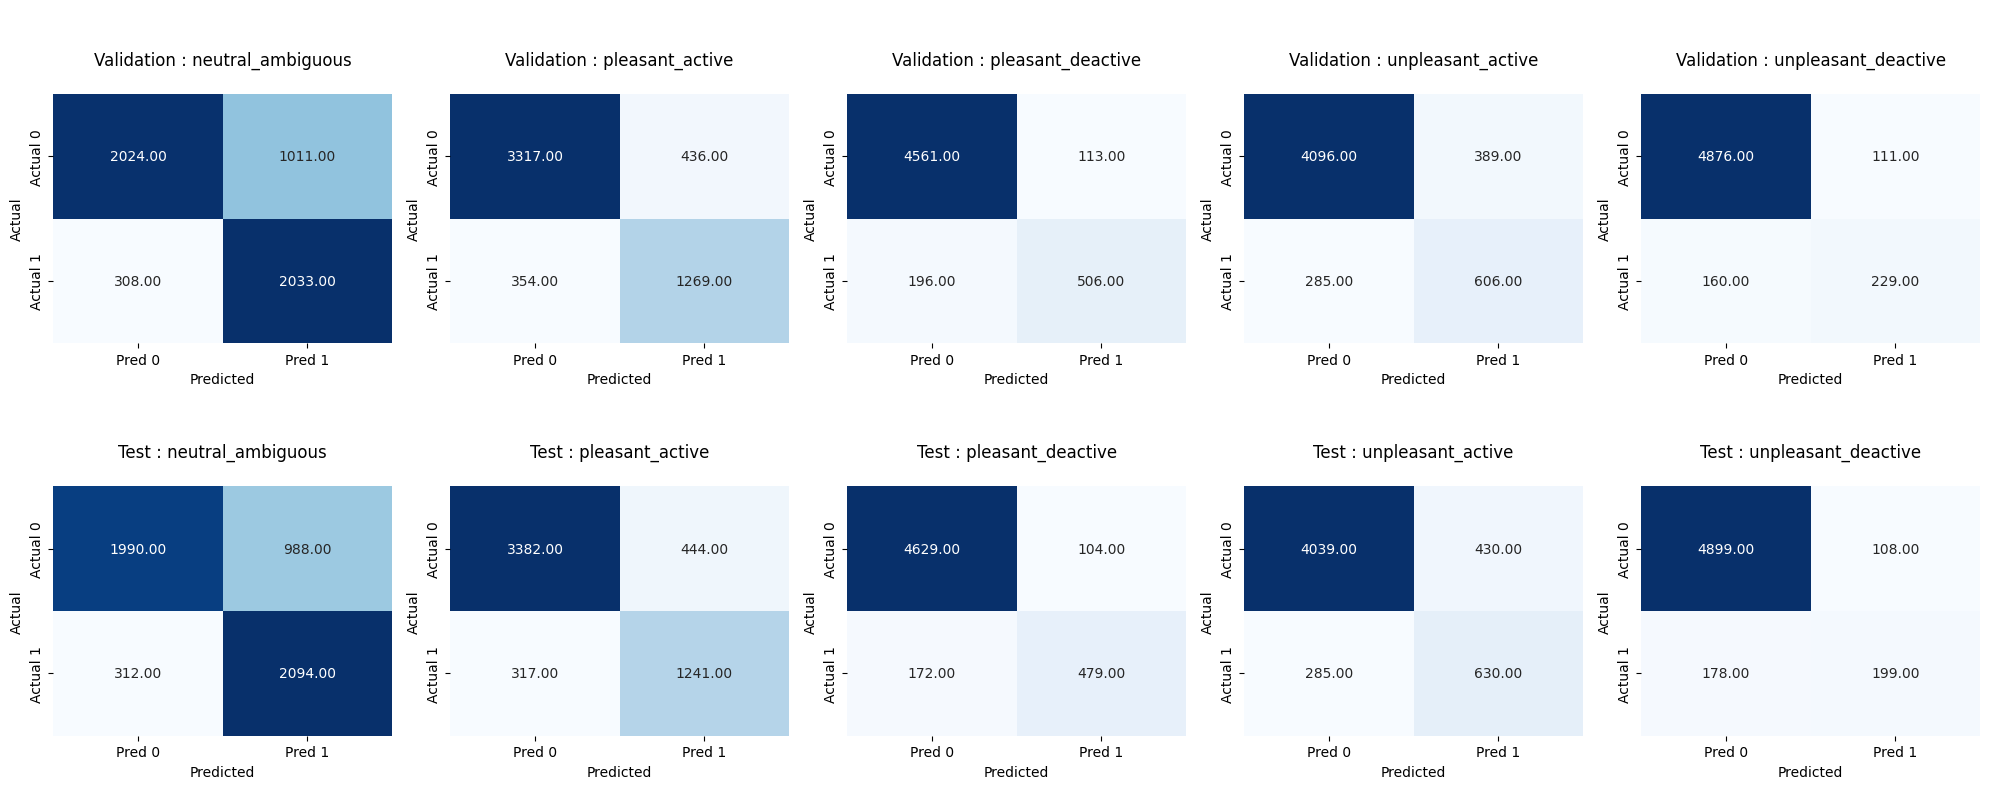

In [41]:
#compute per-quadrant confusion matrices for val and test splits
cm_val_transformer=utils.confusion_matrices_per_label(
    y_val_cat, val_scores_cat, ts_cat, categories)

cm_test_transformer=utils.confusion_matrices_per_label(
    y_test_cat, test_scores_cat,ts_cat, categories)

#plot val and test confusion matrices for each category
utils.plot_cm(cm_val_transformer, cm_test_transformer, categories, normalize=False)

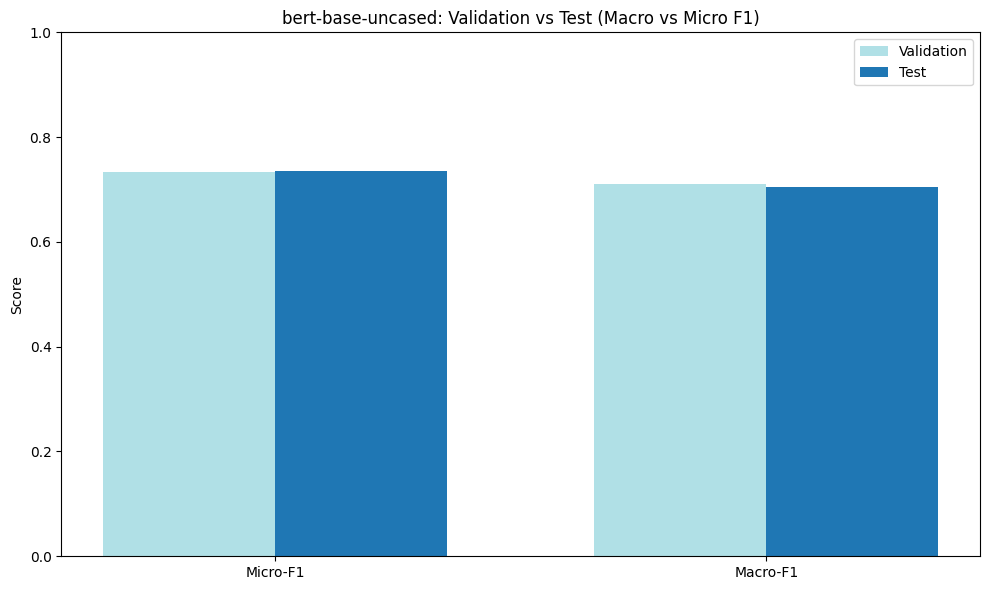

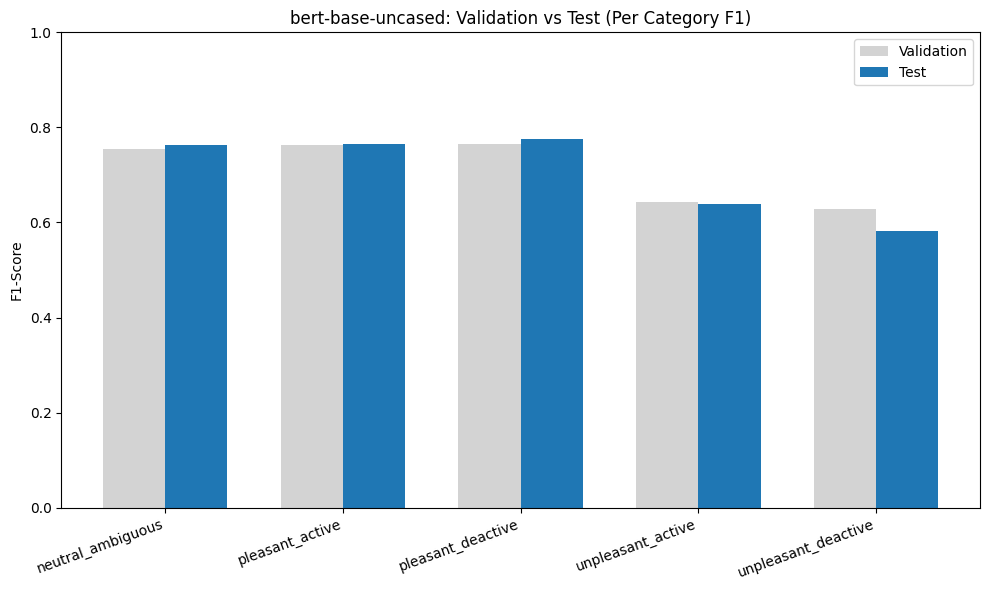

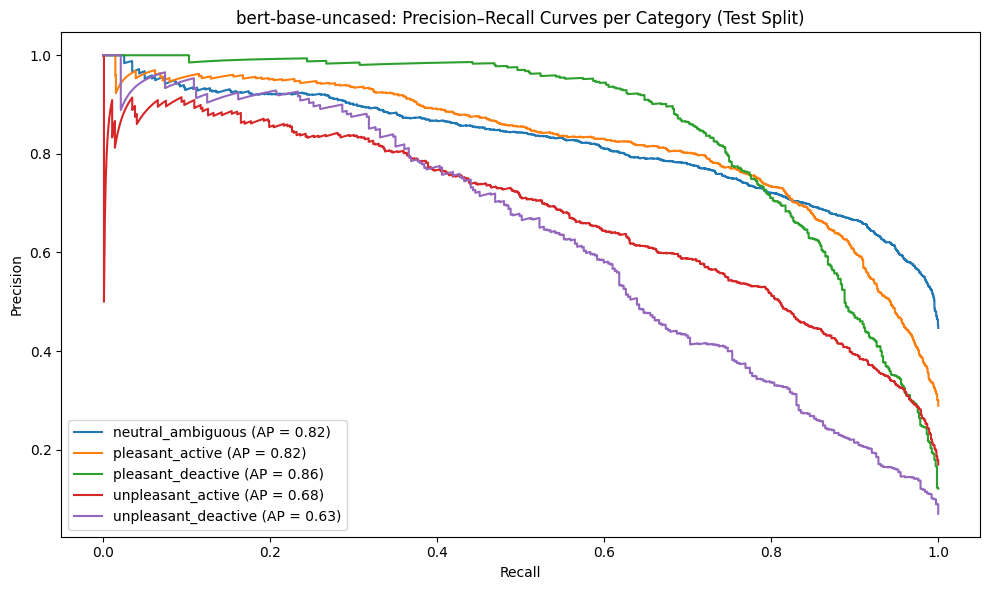

In [42]:
#compare val and test Micro-F1 and Macro-F1 scores for the selected best model
utils.plot_val_test_macro_micro(val_metrics, test_metrics, model_name=overall_best["cfg"]["model_name"])

#compare per-category F1-scores between val and test splits
utils.plot_val_test_per_cat_f1(val_metrics, test_metrics, categories, model_name=overall_best["cfg"]["model_name"])

#plot precision-recall curves for each category on the test split
utils.plot_pr_curves_per_cat(y_test_cat, test_scores_cat, categories, model_name=overall_best["cfg"]["model_name"])

# 6.Map Burnout Indicators from Predicted Quadrants

In [43]:
#determine a burnout-related indicator from quadrant-level predictions using rule-based priority scheme

def burnout_indicator_from_quadrants(pred_row, col_idx):

  #extract binary predictions for each affective quadrant
  NEU=int((pred_row[col_idx["neutral_ambiguous"]]))
  PA=int((pred_row[col_idx["pleasant_active"]]))
  PD=int((pred_row[col_idx["pleasant_deactive"]]))
  NA=int((pred_row[col_idx["unpleasant_active"]]))
  ND=int((pred_row[col_idx["unpleasant_deactive"]]))

  #assign a burnout-related indicator using a rule-based priority
  if ND:
    return "Signs of Advanced Burnout (Exhaustion/Ineffectiveness)"
  elif NA:
    return "Signs of Moderate Burnout (Stress/Cynicism)"
  elif PA:
    return "Indicators of Engagement (No Apparent Signs of Burnout)"
  elif PD:
    return "Indicators of Satisfaction (No Apparent Signs of Burnout)"
  elif NEU:
    return "Ambiguous Burnout Indicator"
  else:
    return "Ambiguous Burnout Indicator"

In [44]:
#convert category probabilities to binary predictions using per-label thresholds
preds_cat = (test_scores_cat >= ts_cat).astype(int)

#map quadrant names to their corresponding column indices
col_idx = {c:i for i,c in enumerate(categories)}

#generate burnout-related indicator for each test
labels = [burnout_indicator_from_quadrants(row, col_idx) for row in preds_cat]

In [45]:
#summarise distribution of burnout-related indicators across the test set
pd.Series(labels).value_counts()

,count
Ambiguous Burnout Indicator,2050
Indicators of Engagement (No Apparent Signs of Burnout),1633
Signs of Moderate Burnout (Stress/Cynicism),995
Indicators of Satisfaction (No Apparent Signs of Burnout),399
Signs of Advanced Burnout (Exhaustion/Ineffectiveness),307
